# Exploratory data analysis 
In this notebook, I will perform EDA on the dataset to understand the data better and to get insights from it.
I will mostly follow the steps from the scanpy tutorial on clustering


https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html

# Loading the data 

In [1]:
import numpy as np

cell_file = "./data/cells.npy"
cells = np.load(cell_file, allow_pickle=True).ravel()[0]

expressions = cells["UMI"].toarray()  # sparse matrix of gene expressions
gene_names = cells["gene_ids"]  # gene names
cell_classes = cells["classes"]  # cell classes

In [2]:
# print a few samples to get a feel of the data
print(expressions[:5, :5])
print(gene_names[:5])
print(cell_classes[:5])


[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
['ENSG00000238009' 'ENSG00000228463' 'ENSG00000235373' 'ENSG00000228327'
 'ENSG00000177757']
['CD8+ Cytotoxic T' 'CD8+/CD45RA+ Naive Cytotoxic' 'CD4+/CD45RO+ Memory'
 'CD19+ B' 'CD4+/CD25 T Reg']


<span style='color:green'>We can already notice that the genes use Ensemble ID and we are working with immune cells</span>

# Getting Symbol 

The quality control step in the analysis need to look at mitochondrial genes, ribosomal and hemoglobin genes, so we need to convert the Ensemble ID to gene symbol in order to filter wiht the associated prefixes

In [3]:
import mygene

mg = mygene.MyGeneInfo()

# Query mygene to get the corresponding HGNC symbols
gene_info = mg.querymany(gene_names, scopes='ensembl.gene', fields='symbol', species='human')

# Extract the HGNC symbols
hgnc_symbols = [gene['symbol'] if 'symbol' in gene else 'NA' for gene in gene_info]

# Print the first few results
print(hgnc_symbols[:5])

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-16769...done.
Finished.
550 input query terms found no hit:
	['ENSG00000235373', 'ENSG00000279244', 'ENSG00000269554', 'ENSG00000203301', 'ENSG00000271895', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
['NA', 'RPL23AP21', 'NA', 'NA', 'FAM87B']


# Building the AnnData object

In [8]:
import scanpy as sc
import scipy.sparse as sp

# Create an AnnData object
adata = sc.AnnData(X=sp.csr_matrix(expressions),
                   obs={'cell_classes': cell_classes},
                   var={'gene_names': gene_names})


/home/stephane/miniconda3/envs/py311/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/stephane/miniconda3/envs/py311/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/stephane/miniconda3/envs/py311/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/stephane/miniconda3/envs/py311/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/stephane/miniconda3/envs/py311/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarn

AnnData object with n_obs × n_vars = 65943 × 16769
    obs: 'cell_classes'
    var: 'gene_names'


In [10]:
# Print the AnnData object
print(adata)

AnnData object with n_obs × n_vars = 65943 × 16769
    obs: 'cell_classes'
    var: 'gene_names'


In [9]:
adata.var_names = gene_names
print(adata.obs["cell_classes"].value_counts())

cell_classes
CD8+ Cytotoxic T                20307
CD8+/CD45RA+ Naive Cytotoxic    16361
CD56+ NK                         8522
CD4+/CD25 T Reg                  6116
CD19+ B                          5579
CD4+/CD45RO+ Memory              3031
Dendritic                        1946
CD14+ Monocyte                   1944
CD4+/CD45RA+/CD25- Naive T       1857
CD34+                             188
CD4+ T Helper2                     92
Name: count, dtype: int64


<span style='color:green'>From the previous cell, we can see that the cell types are very imbalanced </span>

# Quality control

In [12]:
import re

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] =  [s.startswith("MT-") for s in hgnc_symbols]
# ribosomal genes
adata.var["ribo"] = [s.startswith(("RPS", "RPL")) for s in hgnc_symbols]
# hemoglobin genes
adata.var["hb"] = [bool(re.search(r"^HB(?!P)", s)) for s in hgnc_symbols]


In [13]:
adata.var["mt"].sum(), adata.var["ribo"].sum(), adata.var["hb"].sum()

(0, 101, 9)

<span style="color:green">We notice there is no Mitochondrial genes in the data, so we will focus on the other gene classes</span>

In [14]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["ribo", "hb"], inplace=True, log1p=True
)

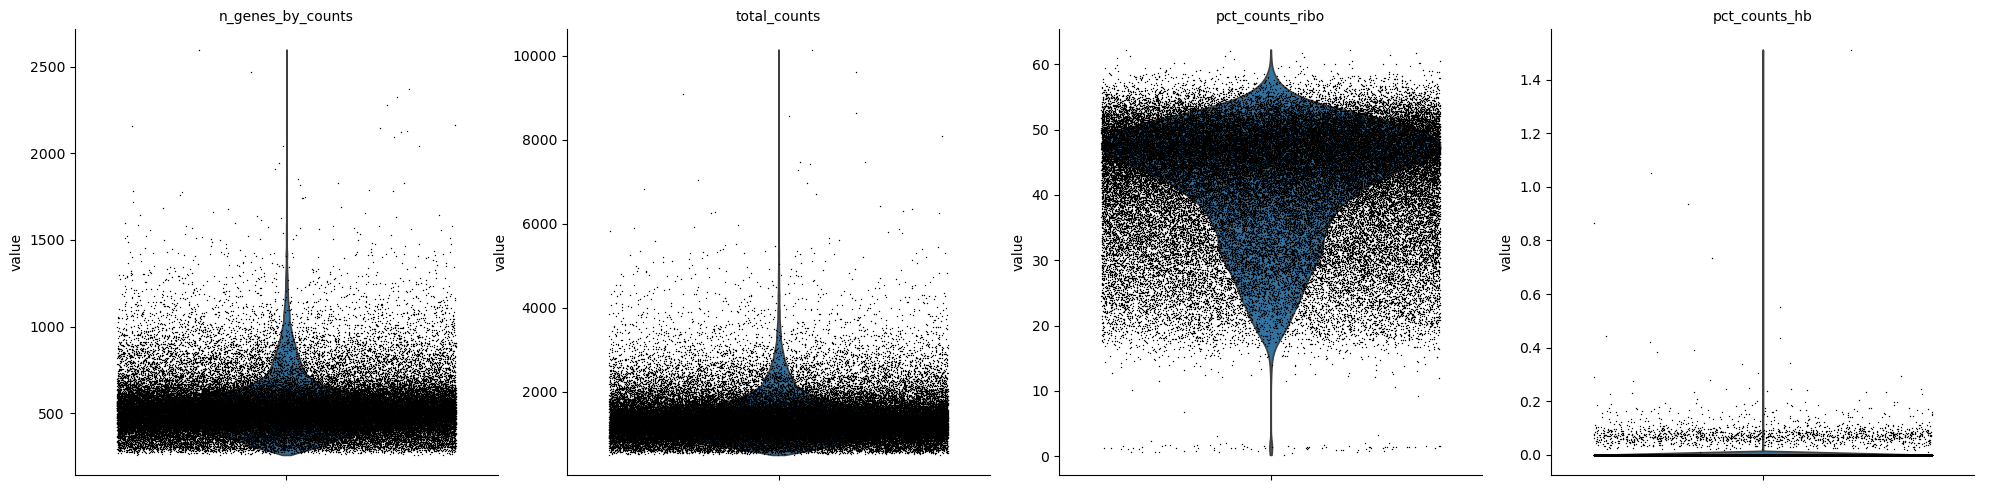

In [15]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4,
    multi_panel=True,
)

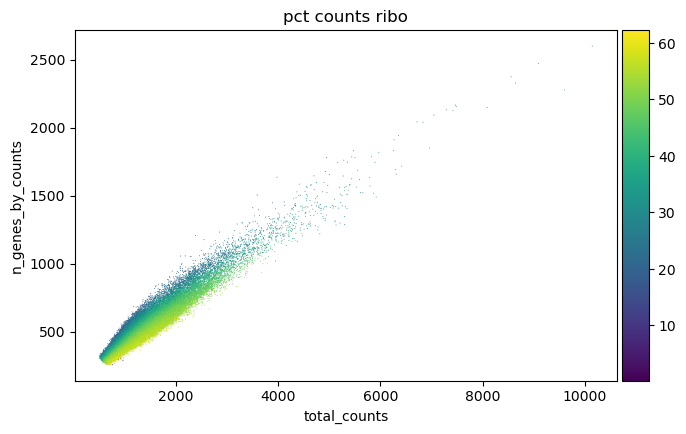

In [17]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_ribo")

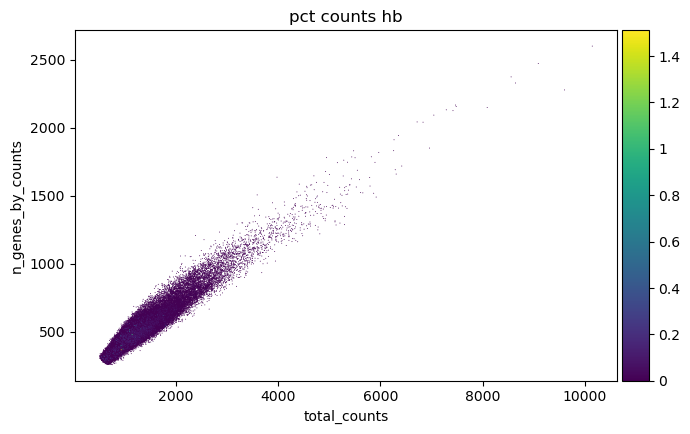

In [18]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_hb")

The previous graph doesn't seem to show anormalities

In [19]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

# Doublet detection

In [20]:
sc.pp.scrublet(adata, batch_key="cell_classes")

# Normalization

In [21]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [22]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# Feature selection

In [ ]:
# this method seems to find the highly variables genes in each batch
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="cell_classes")

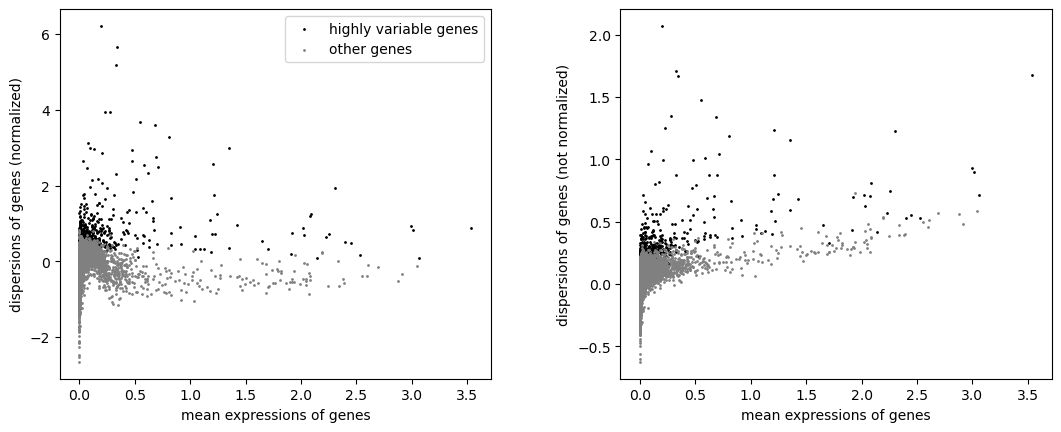

In [24]:
sc.pl.highly_variable_genes(adata)

Idealy I would like to look in more details of this method to find the better way to select the top genes to use in the clustering, the 2000 genes from documentation seems arbitrary 

# Dimensionality reduction

In [25]:
sc.tl.pca(adata)

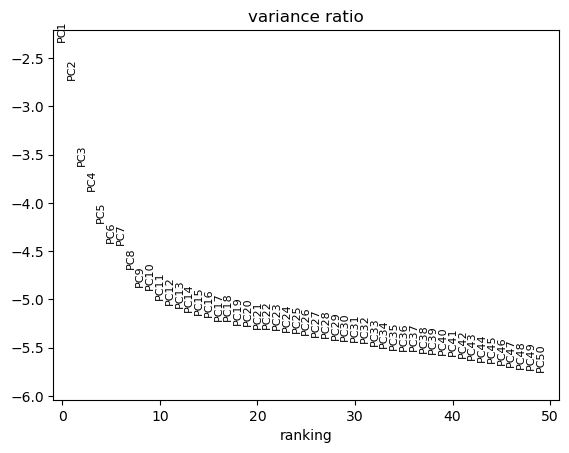

In [26]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

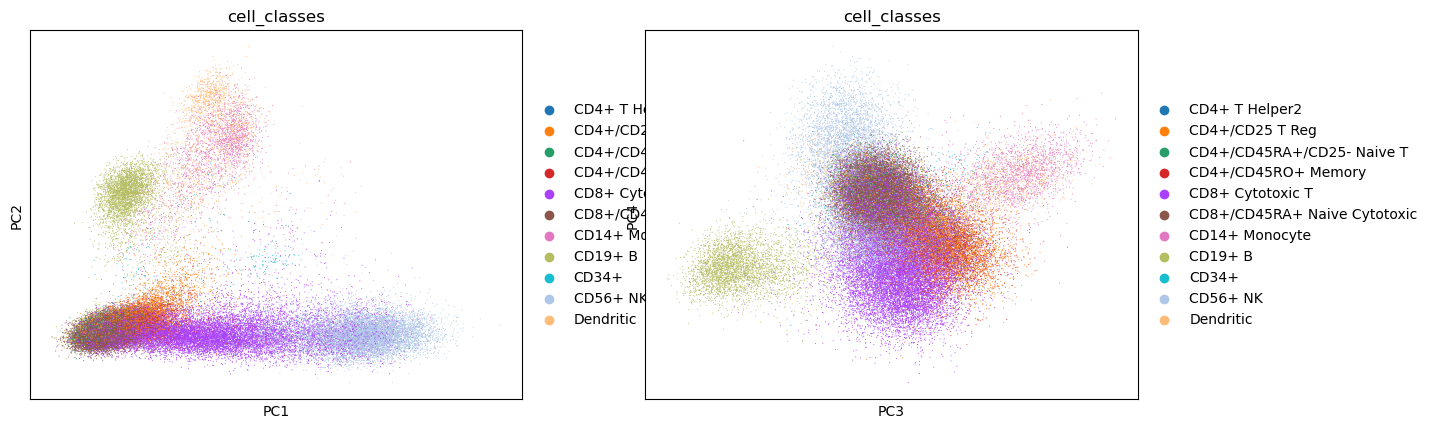

In [27]:
sc.pl.pca(
    adata,
    color=["cell_classes", "cell_classes"],
    dimensions=[(0, 1), (2, 3)],
    ncols=2,
    size=2,
)

The PCA analysis isn't bad, the first 10 components seems to capture a lot of variance, they could be use for dimentiionality reduction, creating a new dataset for training future model 

In [28]:
sc.pp.neighbors(adata)

In [29]:
sc.tl.umap(adata)

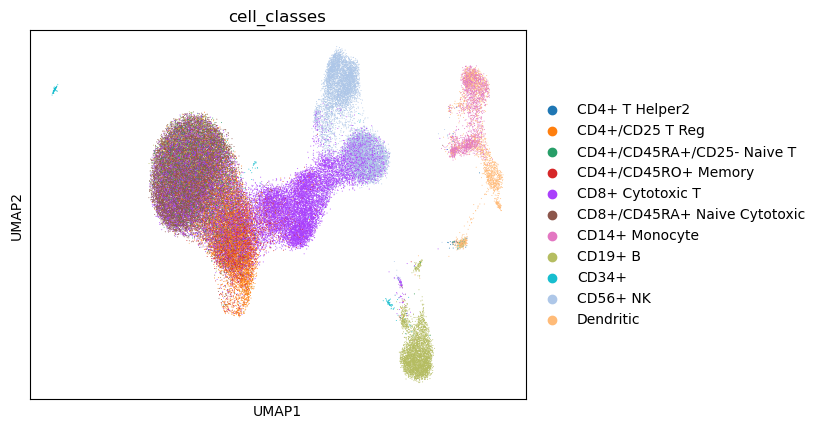

In [30]:
sc.pl.umap(adata, color=['cell_classes'])

# Clustering

In [31]:
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

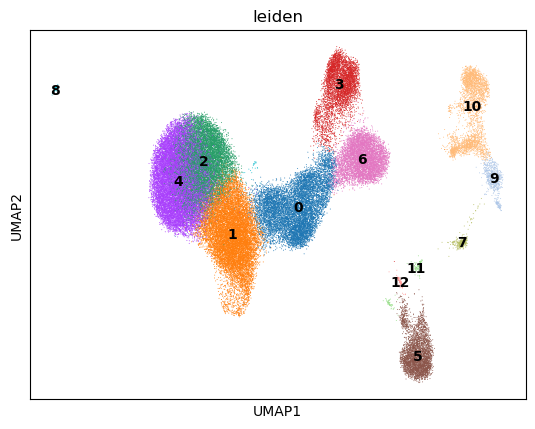

In [32]:
sc.pl.umap(adata, color=["leiden"], legend_loc="on data")

the results looks comparable to the previous neighborhood clustering method, I am not too familiar with this method, but it seems to be a good way to cluster the data

# Re-assess quality control and cell filtering

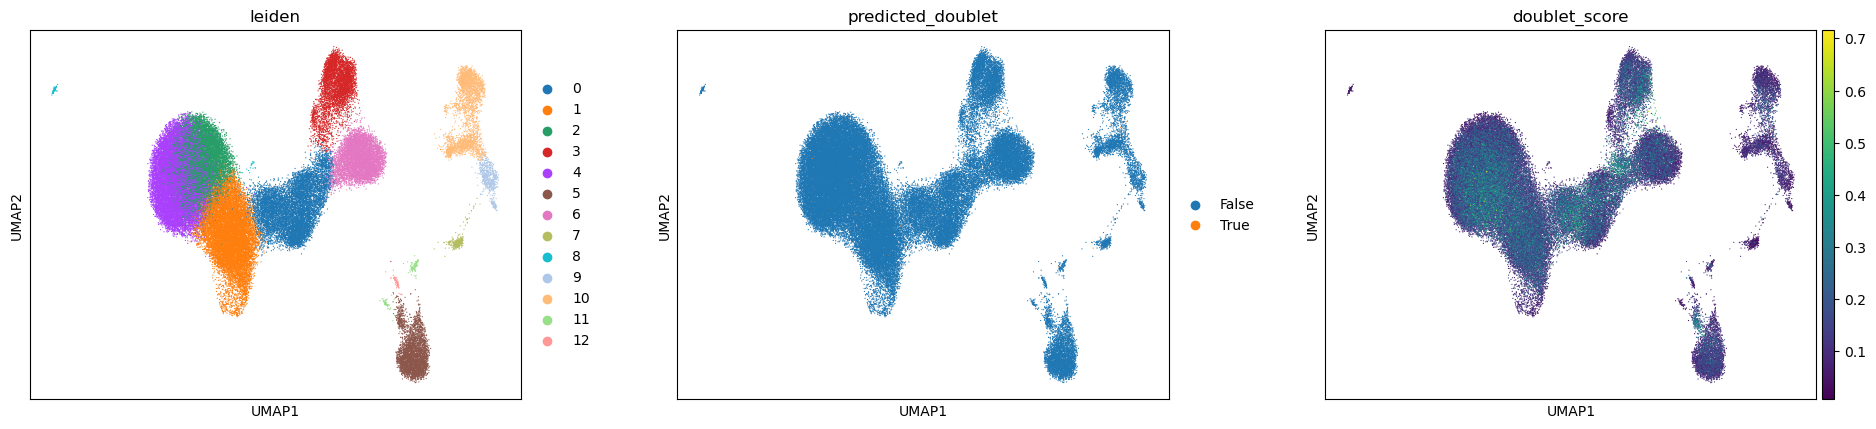

In [33]:
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.2,
    size=3,
)

I am not familiar with scanpy and would need more time to figure out if some of the data need to be taken out. 

# Saving the AnnData object

I am saivin the AnnData to be use in another notebook for the classification task

In [34]:
adata.write('./data/adata.h5ad')